# TM10007 Assignment ECG - group 3

### Imports

In [9]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier


### Data loading, save features and labels into dataframe 

In [2]:
with zipfile.ZipFile('./ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./ecg/')

data = pd.read_csv('./ecg/ecg_data.csv', index_col=0)

file = './ecg/ecg_data.csv'
if(os.path.exists(file) and os.path.isfile(file)):
  os.remove(file)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

y = data.label
X = data.drop('label', axis=1)

The number of samples: 827
The number of columns: 9001


## PCA plot to visualize data

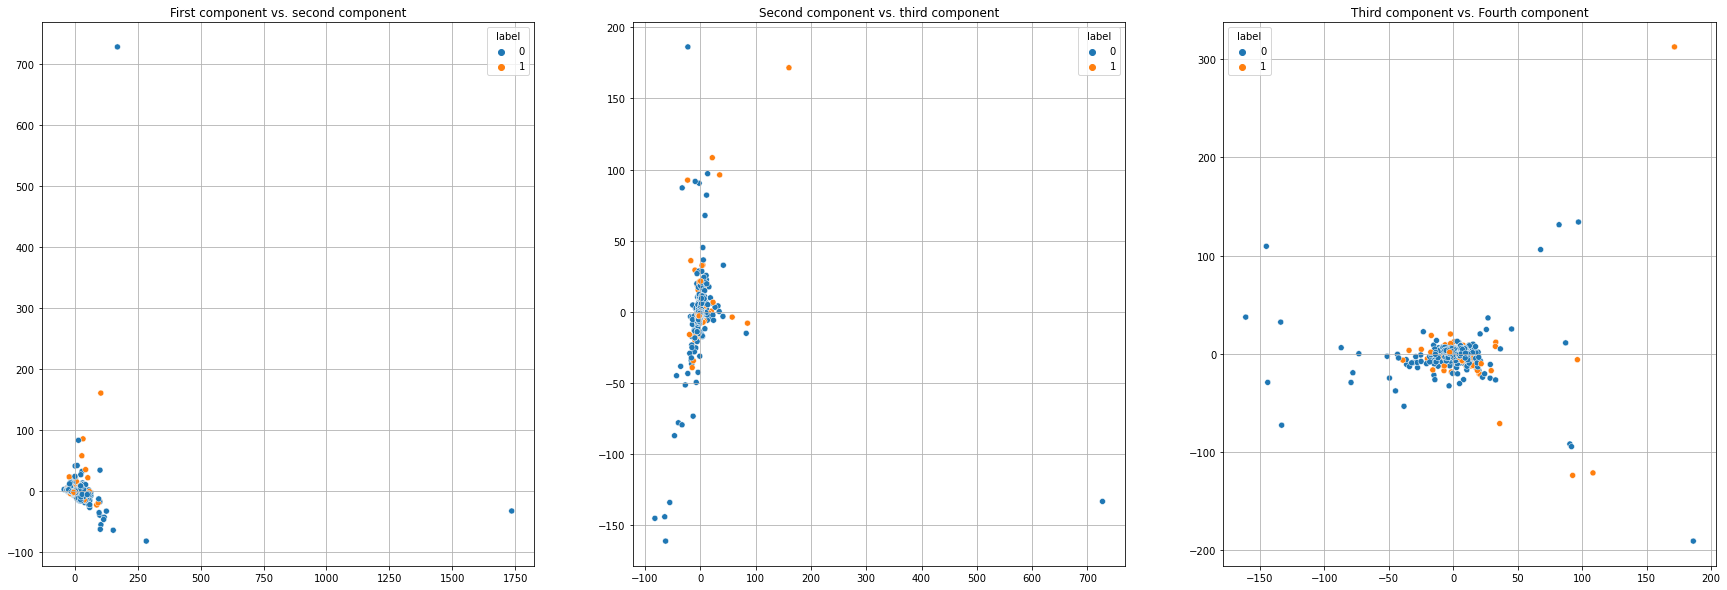

In [36]:
# PCA plot of all data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

fig, axs = plt.subplots(1, 3, figsize=(30,10))
seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=axs[0])
axs[0].set_title('First component vs. second component')
axs[0].grid()
seaborn.scatterplot(x=X_pca[:, 1], y=X_pca[:, 2], hue=y, ax=axs[1])
axs[1].set_title('Second component vs. third component')
axs[1].grid()
seaborn.scatterplot(x=X_pca[:, 2], y=X_pca[:, 3], hue=y, ax=axs[2])
axs[2].set_title('Third component vs. Fourth component')
axs[2].grid()

(0.0, 75.0)

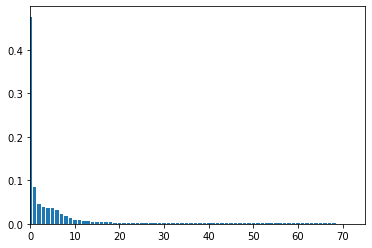

In [40]:
plt.bar(x=range(pca.explained_variance_ratio_.shape[0]), height=pca.explained_variance_ratio_)
plt.xlim([0, 75])

In [38]:
pca.explained_variance_ratio_.shape[0]

827

### Learning Curve function 

In [3]:
def plot_learning_curve(clf, X_train, y_train, plot):
    train_size, train_scores, test_scores = learning_curve(clf, X, y, verbose=2)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot.plot(train_size, train_mean, color='b', label='training')
    plot.plot(train_size, test_mean, color='orange', label='validation')

    plot.fill_between(train_size, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
    plot.fill_between(train_size, test_mean-test_std, test_mean+test_std, color='orange', alpha=0.3)
    
    plot.grid()
    plot.set_ylim([0, 1.1])
    plot.set_xlabel('Training examples')
    plot.set_ylabel('Score')
    plot.legend()

# Random forest classifier 

### Loop of test-training  and evaluation loop

In [ ]:
# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []
n = -1

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    random_forest = RandomForestClassifier()
    pca = PCA()

    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ("random_forest", random_forest)])

    # GridSearch

    # Random grid:
    n_estimators = [int(x) for x in np.linspace(start=50, stop=200)]
    max_features = ['auto', 'sqrt', 'log2', 0.1]
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    min_samples_leaf = [1, 3, 5]
    bootstrap = [True, False]

    random_grid = {'random_forest__n_estimators': n_estimators,
    'random_forest__max_features': max_features,
    'random_forest__max_depth': max_depth,
    'random_forest__min_samples_leaf': min_samples_leaf,
    'random_forest__bootstrap': bootstrap}


    #parameters = {'random_forest__n_estimators': [50, 100, 200], 'random_forest__max_features': ['sqrt', 'log2'], 'random_forest__min_samples_leaf': [1,3,5]} 
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter=20)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
scores['f1']
# variabiliteit is heeel groot tussen de verschillende test-train splits; hoe komt dat? Hij lijkt niet stabiel. 

In [ ]:

# Denk een goede om van de 5 loops met verschillende test-train split de cv_results overzichtelijk te laten zien; 
# dan krijgen we inzicht in welke hyperparameters betere en minder goed werken; hier begin gemaakt maar hadden geen tijd om het af te maken 
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)


# Naive Bayes

In [ ]:
# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    naive_bayes = GaussianNB()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    # Extra stap in de pipeline is nu de selector, PCA is uit de pipeline
    pipe = Pipeline(steps=[('select', selector), ("nbayes", naive_bayes)])

    # GridSearch

    # Random grid:
    var_smoothing = np.logspace(0,-9, num=100)
    k_select = np.arange(2, 150) # Kijken wat de bovengrens van select moet worden

    random_grid = {'nbayes__var_smoothing': var_smoothing,
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter= 30)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
scores['f1']

In [ ]:
scores['accuracy']

In [ ]:
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)

In [ ]:
scores['f1']

In [ ]:
import pandas as pd
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)

# K-Nearest Neighbours

In [ ]:
# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # Preprocessing
    scaler = StandardScaler()
    knn = KNeighborsClassifier()
    pca = PCA()
    selector = SelectKBest()

    # Pipeline
    # Extra stap in de pipeline is nu de selector, PCA is uit de pipeline
    pipe = Pipeline(steps=[('select', selector), ("knn", knn)])

    # GridSearch

    # Random grid:
    k_range = list(range(1, 31))
    weights = ['uniform', 'distance']
    k_select = np.arange(2, 150) # Kijken wat de bovengrens van select moet worden

    random_grid = {'knn__n_neighbors': k_range,
    'knn__weights': weights,
    'select__k': k_select}

    # Hoeveel iteraties willen we?
    search = RandomizedSearchCV(pipe, random_grid, cv=3, scoring = 'f1', verbose=2, n_iter=20)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i]) # eventueel testen met groot aantal neighbors
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
for i, clf in enumerate(fitted_clf_list): 
    print(f'Results for split {i+1}:')
    param_df = pd.DataFrame(clf.cv_results_)

    cols = [c for c in param_df.columns if c.lower()[:5] != 'split']

    param_df = param_df[cols].sort_values(by='rank_test_score')
    display(param_df)

In [ ]:
scores['f1']

In [ ]:
scores['accuracy']

# SVM

In [ ]:
from sklearn import svm

# Aantal splits
N_SPLITS = 5

# Kijken of stratified shuffle een betere stabiliteit geeft
rs = ShuffleSplit(n_splits=N_SPLITS, test_size=.3) ## moeten voordat we hem inleveren nog random state toevoegen! 

scores = {'f1': [], 'accuracy': []}    ## Wat is een andere score die wat meer zegt dan accuracy? Of alleen F1? 
fitted_clf_list = []

fig, axs = plt.subplots(N_SPLITS, figsize=(10, 10))

for i, (train_index, test_index) in enumerate(rs.split(X, y)):

    # Data split
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_test = X.iloc[test_index]
    y_test = y[test_index]

    # PCA plot of training data
    #scaler = svm.SVRT()
    #scaler.fit(X_train)
    #X_scaled = scaler.transform(X_train)

# we dachten PCA scatterplots van verschillende data toevoegen in subplot 
    #pca = decomposition.PCA(n_components=3)
    #pca.fit(X_scaled)
    #X_pca = pca.transform(X_scaled)
    #ax = plt.subplot(3, 2, n + 1)
    #seaborn.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, ax=ax)

    # Preprocessing
    scaler = StandardScaler()
    pca = PCA()

    # classifier 
    classifier = svm.SVC()
    # Pipeline
    pipe = Pipeline(steps=[('scaler', scaler), ('svm', classifier)])

    # GridSearch

    # Random grid:
    random_grid = {
        #'pca__n_components': [None, 10,50,100],
            'svm__C': list(np.arange(0.01,100, 5)),
            'svm__gamma': list(np.arange(0.001, 1, 0.05)), 
            'svm__kernel': ['rbf', 'poly', 'linear']} 


    search = RandomizedSearchCV(pipe, random_grid, cv=3, verbose=5, scoring = 'f1', n_iter= 20)
    search.fit(X_train, y_train)
    best_clf = search.best_estimator_
    fitted_clf_list.append(search)

    y_pred = best_clf.predict(X_test)
    scores['f1'] += [f1_score(y_test, y_pred)]
    scores['accuracy'] += [accuracy_score(y_test, y_pred)]
    
    plot_learning_curve(best_clf, X_train, y_train, axs[i])
    fig.suptitle(f'Learning curve for {str(type(best_clf[-1])).split(".")[-1][:-2]}')
plt.show()

In [ ]:
scores['f1']

In [ ]:
scores['accuracy']